In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Data Loading

In [71]:
df = pd.read_csv('/content/sample_data/processed.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df

,Institution,Course,actor.id,timestamp,verb.id,object.definition.type,result.score.scaled,result.success,result.completion,Teaching
0,UEF,Advanced Data Management Systems,0,2023-07-07 18:55:47,viewed,course,NaN,False,False,Flipped classroom
1,UEF,Advanced Data Management Systems,0,2023-07-07 15:21:18,viewed,link,NaN,False,False,Flipped classroom
2,UEF,Advanced Data Management Systems,0,2023-07-07 15:08:13,viewed,link,NaN,False,False,Flipped classroom
3,UEF,Advanced Data Management Systems,0,2023-07-07 15:08:10,viewed,course,NaN,False,False,Flipped classroom
4,UEF,Advanced Data Management Systems,0,2023-07-07 09:03:32,viewed,course,NaN,False,False,Flipped classroom
...,...,...,...,...,...,...,...,...,...,...
299286,BMU,Computer Networks,820,2023-06-11 22:57:27,answered,cmi.interaction,1.000,True,True,Flipped classroom
299287,BMU,Computer Networks,799,2023-05-16 00:05:45,answered,cmi.interaction,0.000,False,True,Flipped classroom
299288,BMU,Computer Networks,788,2023-05-12 22:10:50,completed,assessment,0.375,True,True,Flipped classroom
299289,BMU,Computer Networks,788,2023-02-27 22:45:33,completed,module,NaN,False,False,Flipped classroom


In [169]:
df[~df['result.score.scaled'].isna()][['verb.id', 'object.definition.type']].value_counts()

verb.id    object.definition.type
scored     assessment                4235
answered   cmi.interaction           3014
completed  assessment                2509
           quiz                      1800
dtype: int64

# Task 3.

In [201]:
def get_actions(df, min_time = None, max_time = None):

  if min_time is None and max_time is None:
    min_time = df.index[0]
    max_time = df.index[-1]

  activities_by_days = dict()
  activities_by_days['timestamp'] = []
  activities_by_days['assessments'] = []
  activities_by_days['non_assessments'] = []
  activities_by_days['total'] = []

  non_assessment_activities = ['resource', 'discussion', 'link', 'page', 'module', 'quiz', 'homework', 'test', 'forum-topic', 'review', 'course']
  time = min_time
  while time <= max_time:
    next_time = time + pd.Timedelta(days=1)
    daily_df = df[(df.index >= time) & (df.index < next_time)]

    activities_by_days['timestamp'].append(time)
    activities_by_days['assessments'].append(daily_df[(~daily_df['result.score.scaled' ].isna()) & (daily_df['object.definition.type'] != 'cmi.interaction')].shape[0])
    activities_by_days['non_assessments'].append(daily_df[(daily_df['object.definition.type'].isin(non_assessment_activities)) & (daily_df['result.score.scaled'].isna())].shape[0])
    activities_by_days['total'].append(daily_df.shape[0])

    time = next_time

  activity_df = pd.DataFrame(activities_by_days).set_index('timestamp')

  return activity_df

def actor_timeline(df, actor_id):
  actor_df = df[df['actor.id'] == actor_id]
  actor_df = actor_df.set_index('timestamp').sort_index()

  colours = {'UEF': 'red', 'SU': 'blue', 'UL': 'green', 'BMU': 'yellow'}
  min_time = pd.Timestamp(min(df['timestamp']).year, min(df['timestamp']).month, min(df['timestamp']).day)
  max_time = pd.Timestamp(max(df['timestamp']).year, max(df['timestamp']).month, max(df['timestamp']).day)

  actor_actions = get_actions(actor_df, min_time, max_time)
  institution_colour = colours[actor_df['Institution'].iloc[0]]
  return actor_actions, institution_colour

def display_actions(df, actor_id, metric):
  actor_actions, institution_colour = actor_timeline(df, actor_id)

  plt.figure(figsize=(10, 5))
  plt.plot(actor_actions.index, actor_actions[metric], c = institution_colour)
  plt.xticks(rotation=45, ha='right')

  plt.xlabel('Date')
  plt.ylabel('Count')
  plt.title('Activity')

  plt.tight_layout()
  plt.show()

# Sol 2:
# def actor_timeline(df, actor_id, freq):
#  actor_df = df[df['actor.id'] == actor_id]
#  actor_df = actor_df.set_index('timestamp').sort_index()
#
#  colours = {'UEF': 'red', 'SU': 'blue', 'UL': 'green', 'BMU': 'yellow'}
#
#  actor_actions = get_actions(actor_df[['verb.id', 'object.definition.type']], freq)
#  institution_colour = colours[actor_df['Institution'].iloc[0]]
#  return actor_actions, institution_colour
#
# def get_actions(df, freq):
#  time_freq = {'D': 1, 'W': 7, 'M': 30}
#  min_time = df.index[0]
#  max_time = df.index[-1]
#
#  activities_by_days = dict()
#  activities_by_days['timestamp'] = []
#  activities_by_days['assessments_and_quizzes'] = []
#  activities_by_days['total'] = []
#  time = min_time
#
#  running = True
#
#  while time <= max_time:
#    next_time = time + pd.Timedelta(days=time_freq[freq])
#    daily_df = df[(df.index >= time) & (df.index < next_time)]
#
#    activities_by_days['timestamp'].append(time)
#    activities_by_days['assessments_and_quizzes'].append(daily_df[(daily_df['object.definition.type'] == 'assessment') | (daily_df['object.definition.type'] == 'quiz')].shape[0])
#    activities_by_days['total'].append(daily_df.shape[0])
#
#    time = next_time
#
#  activity_df = pd.DataFrame(activities_by_days).set_index('timestamp')
#
#  return activity_df

In [186]:
def course_or_institution_timeline(df, name):
  object_type = 'Course'
  if name in set(df['Institution']):
    object_type = 'Institution'

  object_df = df[df[object_type] == name]
  object_df = object_df.set_index('timestamp').sort_index()

  colours = {'UEF': 'red', 'SU': 'blue', 'UL': 'green', 'BMU': 'yellow'}
  min_time = pd.Timestamp(min(df['timestamp']).year, min(df['timestamp']).month, min(df['timestamp']).day)
  max_time = pd.Timestamp(max(df['timestamp']).year, max(df['timestamp']).month, max(df['timestamp']).day)

  object_actions = get_actions(object_df)
  institution_colour = colours[object_df['Institution'].iloc[0]]
  return object_actions, institution_colour

def display_course_or_institution_actions(df, name, metric):
  object_actions, institution_colour = course_or_institution_timeline(df, name)

  plt.figure(figsize=(10, 5))
  if metric == 'both':
    plt.plot(object_actions.index, object_actions['non_assessments'], c = institution_colour)
    plt.plot(object_actions.index, object_actions['assessments'], c = 'purple')
  else:
    plt.plot(object_actions.index, object_actions[metric], c = institution_colour)

  plt.xticks(rotation=45, ha='right')

  plt.xlabel('Date')
  plt.ylabel('Count')
  plt.title('Activity')

  plt.tight_layout()
  plt.show()

def analyze_time_series(df, name, metric):
  object_actions, institution_colour = course_or_institution_timeline(df, name)

  lag_acf = 30
  lag_pacf = 30
  f, ax = plt.subplots(nrows=2, ncols=1)
  plot_acf(object_actions[metric], lags=lag_acf, ax=ax[0])
  plot_pacf(object_actions[metric], lags=lag_pacf, ax=ax[1], method='ols')
  plt.tight_layout()
  plt.show()

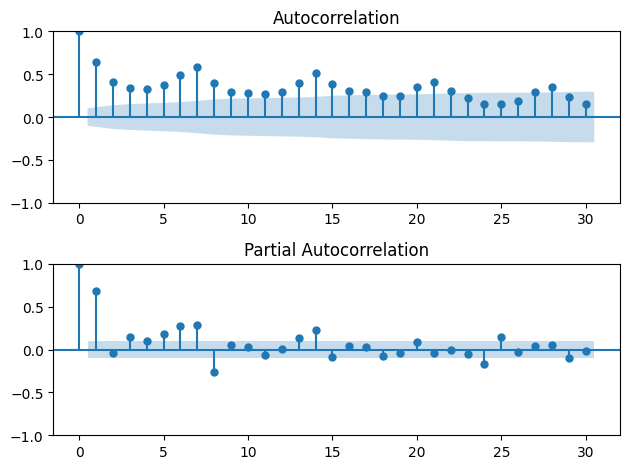

In [176]:
analyze_time_series(df, 'Web Applications', 'total')

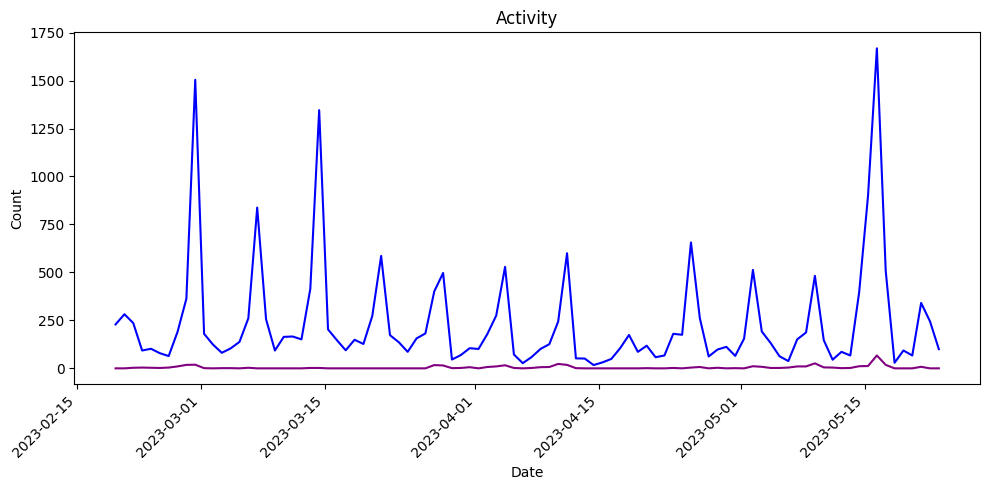

In [205]:
display_course_or_institution_actions(df, 'e-Learning', 'both')

In [53]:
color_df = pd.DataFrame({
    'Institution': df['Institution'].unique(),
    'color': ['red', 'blue', 'green', 'yellow']
})
color_df = color_df.merge(df[['Course', 'Institution']].drop_duplicates(), how='left')
color_df

,Institution,color,Course
0,UEF,red,Advanced Data Management Systems
1,UEF,red,Human Factors of Interactive Technology
2,SU,blue,Human-computer interaction
3,SU,blue,e-Learning
4,UL,green,Computer Architecture
5,UL,green,Web Applications
6,BMU,yellow,Computer Organization
7,BMU,yellow,Computer Networks


In [143]:
df[df['Institution'] == 'UEF']['timestamp'].sort_values()

18434   2023-02-01 05:34:21
18433   2023-02-01 08:11:54
18432   2023-02-01 08:13:06
18431   2023-02-01 08:14:44
18430   2023-02-01 08:15:01
                ...        
1       2023-07-07 15:21:18
0       2023-07-07 18:55:47
18437   2023-07-07 21:08:51
18436   2023-07-07 21:10:01
18435   2023-07-07 21:54:10
Name: timestamp, Length: 153290, dtype: datetime64[ns]